<center><h1>Exploring Transfer Learning and Fine-Tuning in Convolutional Neural Networks</h1>
<h2>Matthias Bartolo</h2>

</center>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

### Added new package installations

In [2]:
from time import time
import tensorflow as tf
import numpy as np
import seaborn as sns

import random
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

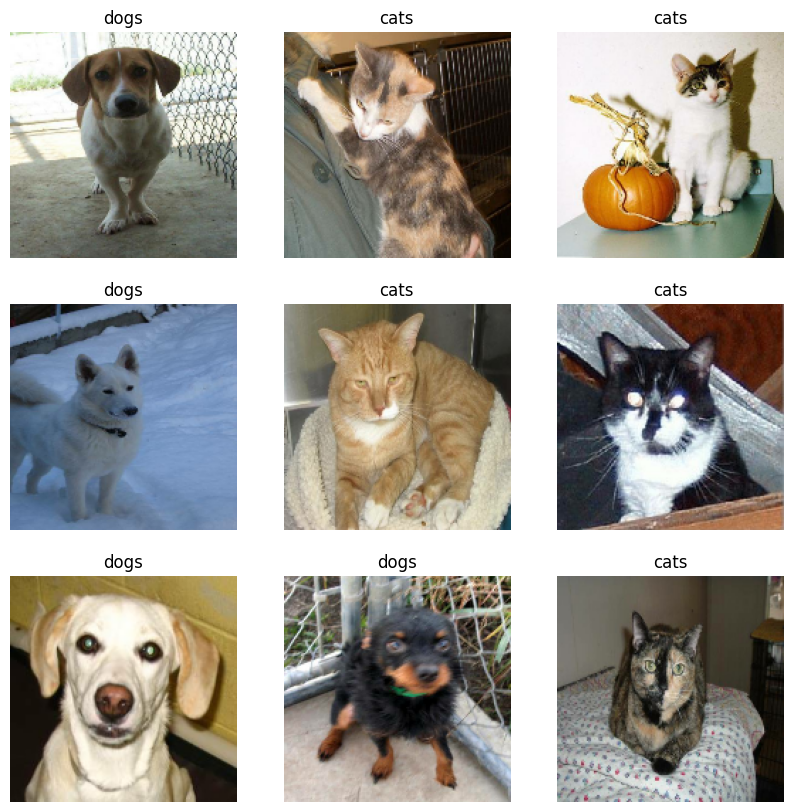

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

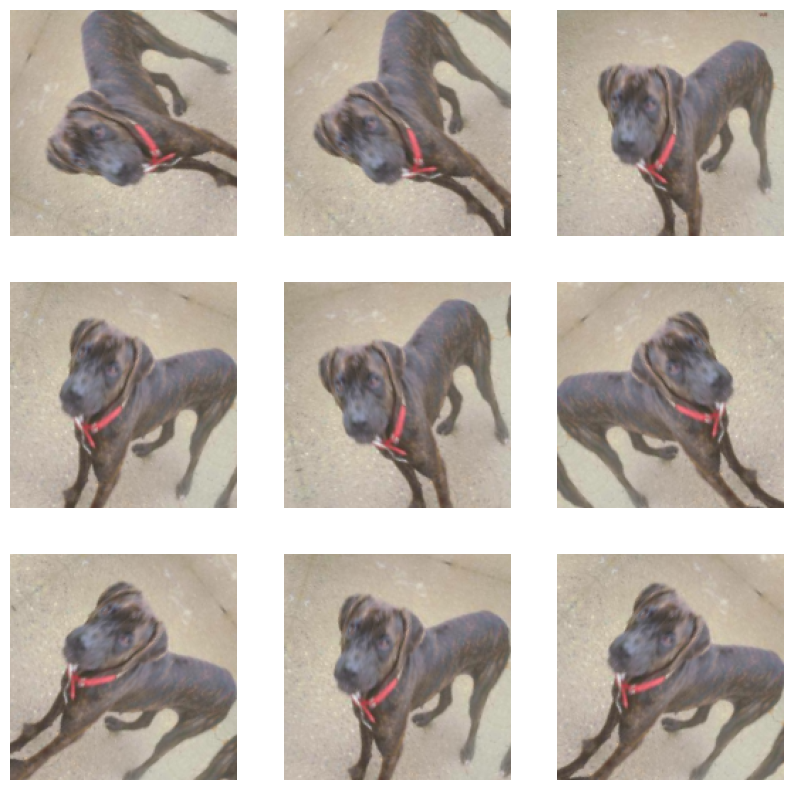

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [31]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [32]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [33]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [35]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [36]:
def build(new_base_model=base_model, preprocess_input=preprocess_input, global_average_layer=global_average_layer, prediction_layer=prediction_layer):
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = new_base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [37]:
model = build()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [38]:
len(model.trainable_variables)

2

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [40]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [41]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 1s 10ms/step - loss: 0.7402 - accuracy: 0.5619


In [42]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.74
initial accuracy: 0.56


In [43]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 6s 66ms/step - loss: 0.7812 - accuracy: 0.5365 - val_loss: 0.6922 - val_accuracy: 0.5817
Epoch 2/10
63/63 [==============================] - 4s 63ms/step - loss: 0.7652 - accuracy: 0.5355 - val_loss: 0.6722 - val_accuracy: 0.6200
Epoch 3/10
63/63 [==============================] - 4s 63ms/step - loss: 0.7175 - accuracy: 0.5840 - val_loss: 0.6356 - val_accuracy: 0.6535
Epoch 4/10
63/63 [==============================] - 4s 63ms/step - loss: 0.6927 - accuracy: 0.5950 - val_loss: 0.6097 - val_accuracy: 0.6819
Epoch 5/10
63/63 [==============================] - 4s 63ms/step - loss: 0.6710 - accuracy: 0.6130 - val_loss: 0.5934 - val_accuracy: 0.6943
Epoch 6/10
63/63 [==============================] - 5s 80ms/step - loss: 0.6772 - accuracy: 0.6205 - val_loss: 0.5734 - val_accuracy: 0.7042
Epoch 7/10
63/63 [==============================] - 7s 106ms/step - loss: 0.6612 - accuracy: 0.6205 - val_loss: 0.5594 - val_accuracy: 0.7327
Epoch 8/10
63/63 [=====

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

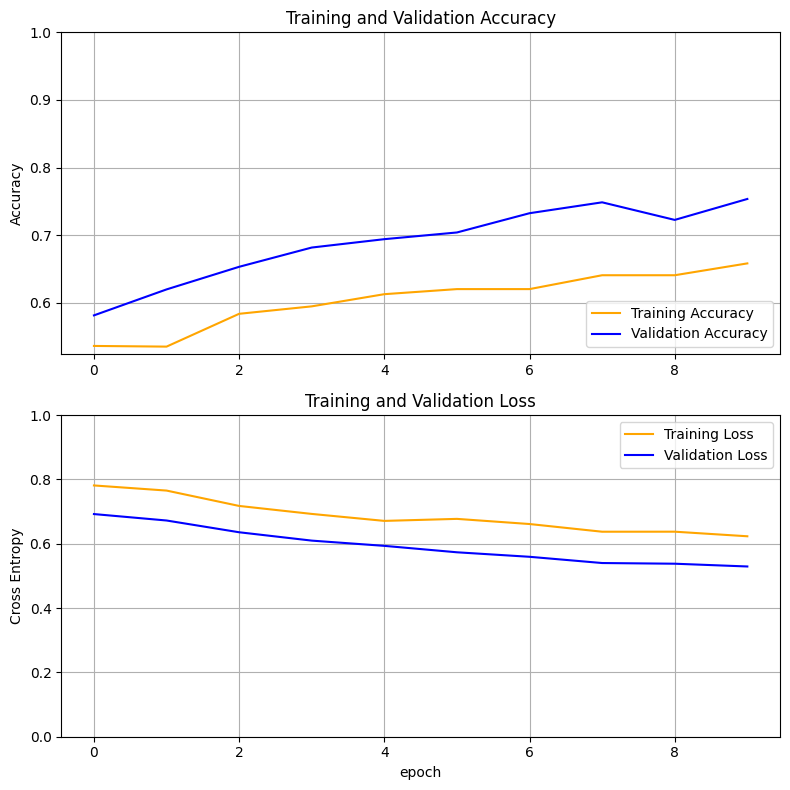

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='orange')
plt.plot(val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='orange')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.tight_layout()
plt.show()

In [68]:
def train(model, learning_rate=0.0001, epochs=10, optimizer=tf.keras.optimizers.Adam, plot_label=False, title='Training and Validation Accuracy'):
    """
        Function to train the model

        Args:
            model: Model to train
            learning_rate: Learning rate for the optimizer
            epochs: Number of epochs to train
            optimizer: Optimizer to use for training
            plot_label: Flag to indicate whether to save the results  as an epoch and not as a learning rate

        Returns:
            History of the training
    """
    # Compiling the model
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])
    
    # Training the model
    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=validation_dataset)

    # Retrieving the accuracy and loss values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the training and validation accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color='orange')
    plt.plot(val_acc, label='Validation Accuracy', color='blue')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.axvline(np.argmax(val_acc), linestyle='--', color='purple', label='Best Validation Accuracy: ' + str(np.max(val_acc)))
    plt.legend(loc='lower right')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss', color='orange')
    plt.plot(val_loss, label='Validation Loss', color='blue')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(title)
    plt.xlabel('epoch')
    plt.grid()
    plt.tight_layout()
    plt.axvline(np.argmin(val_loss), linestyle='--', color='purple', label='Best Validation Loss: ' + str(np.min(val_loss)))
    plt.legend(loc='upper right')

    # Saving the plot
    if not os.path.exists('plots'):
        os.mkdir('plots')
    
    if plot_label:
        plt.savefig('plots/' + str(epochs) + '.png')
    else:
        plt.savefig('plots/' + str(learning_rate) + '.png')
    plt.show()

    return history

Learning rate: 0.0001
Epoch 1/10
63/63 [==============================] - 6s 69ms/step - loss: 0.2998 - accuracy: 0.8850 - val_loss: 0.1443 - val_accuracy: 0.9604
Epoch 2/10
63/63 [==============================] - 4s 64ms/step - loss: 0.2453 - accuracy: 0.9050 - val_loss: 0.1305 - val_accuracy: 0.9666
Epoch 3/10
63/63 [==============================] - 4s 65ms/step - loss: 0.2102 - accuracy: 0.9180 - val_loss: 0.1233 - val_accuracy: 0.9641
Epoch 4/10
63/63 [==============================] - 4s 65ms/step - loss: 0.2048 - accuracy: 0.9215 - val_loss: 0.1082 - val_accuracy: 0.9703
Epoch 5/10
63/63 [==============================] - 7s 106ms/step - loss: 0.1997 - accuracy: 0.9275 - val_loss: 0.1061 - val_accuracy: 0.9715
Epoch 6/10
63/63 [==============================] - 7s 105ms/step - loss: 0.1880 - accuracy: 0.9280 - val_loss: 0.0983 - val_accuracy: 0.9740
Epoch 7/10
63/63 [==============================] - 6s 92ms/step - loss: 0.1873 - accuracy: 0.9325 - val_loss: 0.0927 - val_accura

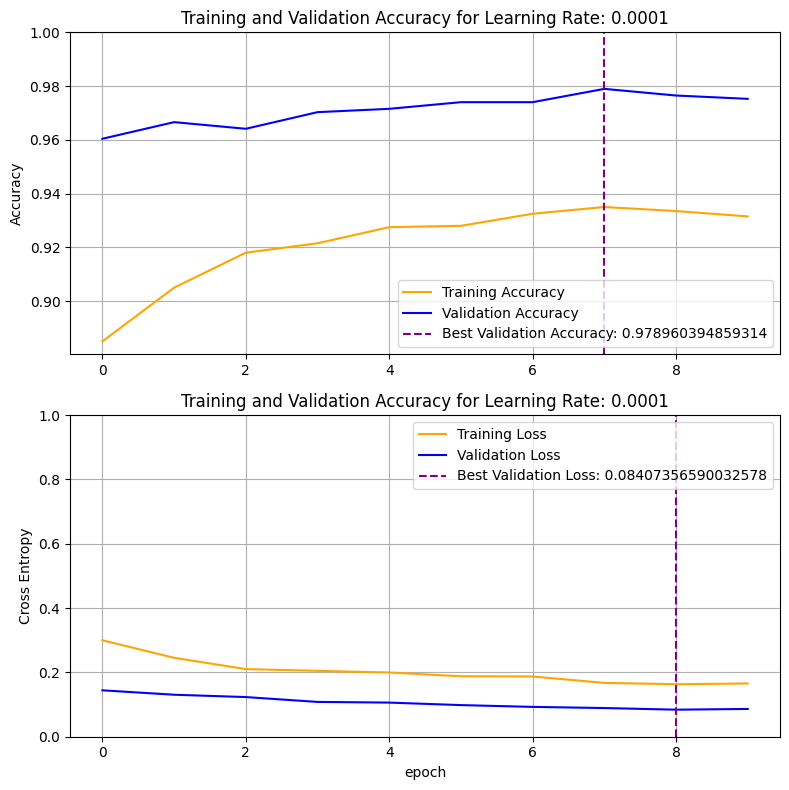

Learning rate: 0.001
Epoch 1/10
63/63 [==============================] - 7s 80ms/step - loss: 0.1557 - accuracy: 0.9335 - val_loss: 0.0614 - val_accuracy: 0.9802
Epoch 2/10
63/63 [==============================] - 4s 65ms/step - loss: 0.1384 - accuracy: 0.9435 - val_loss: 0.0557 - val_accuracy: 0.9802
Epoch 3/10
63/63 [==============================] - 4s 64ms/step - loss: 0.1198 - accuracy: 0.9490 - val_loss: 0.0441 - val_accuracy: 0.9851
Epoch 4/10
63/63 [==============================] - 4s 65ms/step - loss: 0.1146 - accuracy: 0.9545 - val_loss: 0.0455 - val_accuracy: 0.9839
Epoch 5/10
63/63 [==============================] - 4s 66ms/step - loss: 0.1095 - accuracy: 0.9580 - val_loss: 0.0502 - val_accuracy: 0.9790
Epoch 6/10
63/63 [==============================] - 4s 67ms/step - loss: 0.1155 - accuracy: 0.9565 - val_loss: 0.0519 - val_accuracy: 0.9777
Epoch 7/10
63/63 [==============================] - 4s 68ms/step - loss: 0.1049 - accuracy: 0.9565 - val_loss: 0.0463 - val_accuracy:

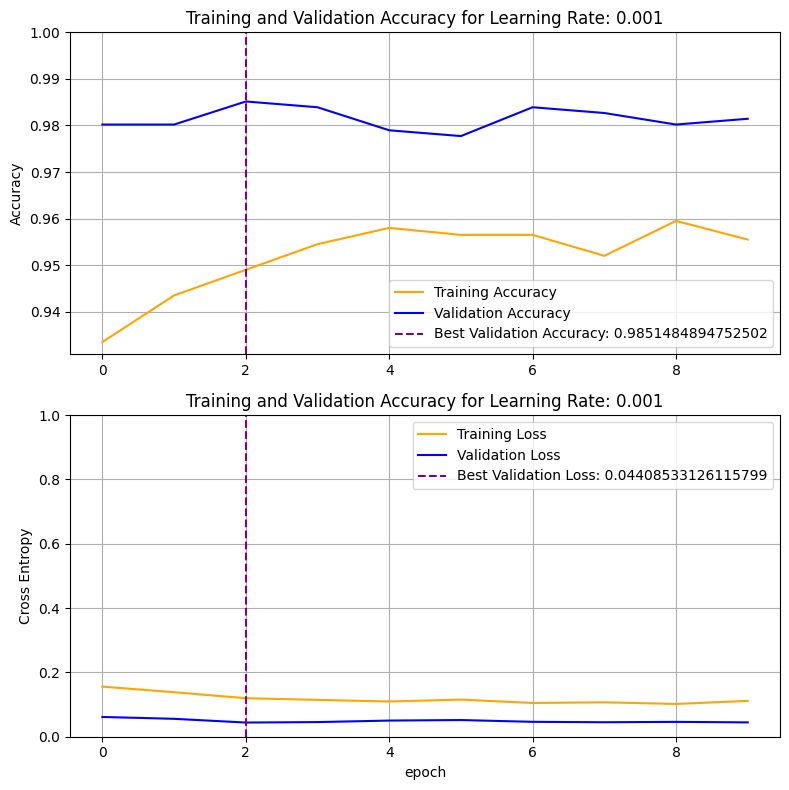

Learning rate: 0.01
Epoch 1/10
63/63 [==============================] - 6s 77ms/step - loss: 0.1658 - accuracy: 0.9425 - val_loss: 0.0490 - val_accuracy: 0.9814
Epoch 2/10
63/63 [==============================] - 4s 67ms/step - loss: 0.1549 - accuracy: 0.9465 - val_loss: 0.0510 - val_accuracy: 0.9802
Epoch 3/10
63/63 [==============================] - 4s 65ms/step - loss: 0.1293 - accuracy: 0.9510 - val_loss: 0.0512 - val_accuracy: 0.9802
Epoch 4/10
63/63 [==============================] - 4s 64ms/step - loss: 0.1345 - accuracy: 0.9530 - val_loss: 0.0455 - val_accuracy: 0.9827
Epoch 5/10
63/63 [==============================] - 4s 63ms/step - loss: 0.1703 - accuracy: 0.9475 - val_loss: 0.0452 - val_accuracy: 0.9839
Epoch 6/10
63/63 [==============================] - 4s 63ms/step - loss: 0.1510 - accuracy: 0.9540 - val_loss: 0.0674 - val_accuracy: 0.9790
Epoch 7/10
63/63 [==============================] - 4s 64ms/step - loss: 0.1573 - accuracy: 0.9610 - val_loss: 0.0485 - val_accuracy: 

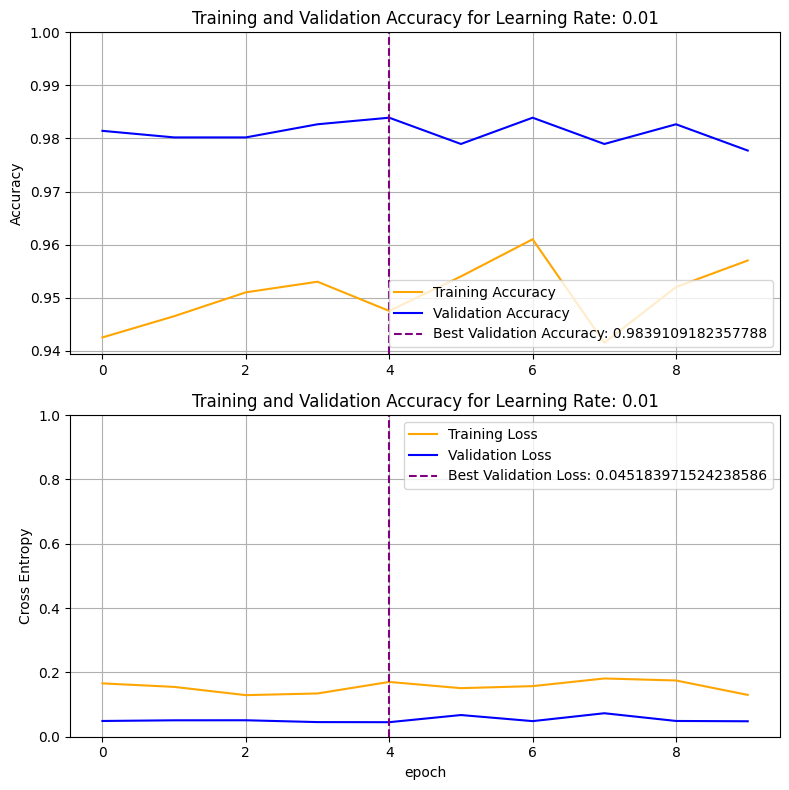

Learning rate: 0.1
Epoch 1/10
63/63 [==============================] - 7s 78ms/step - loss: 1.2477 - accuracy: 0.9090 - val_loss: 0.2459 - val_accuracy: 0.9765
Epoch 2/10
63/63 [==============================] - 4s 64ms/step - loss: 1.1745 - accuracy: 0.9315 - val_loss: 0.2780 - val_accuracy: 0.9814
Epoch 3/10
63/63 [==============================] - 4s 64ms/step - loss: 1.2681 - accuracy: 0.9335 - val_loss: 0.4517 - val_accuracy: 0.9752
Epoch 4/10
63/63 [==============================] - 4s 63ms/step - loss: 0.8961 - accuracy: 0.9485 - val_loss: 0.5157 - val_accuracy: 0.9728
Epoch 5/10
63/63 [==============================] - 4s 63ms/step - loss: 1.0342 - accuracy: 0.9485 - val_loss: 0.4379 - val_accuracy: 0.9752
Epoch 6/10
63/63 [==============================] - 6s 102ms/step - loss: 1.4160 - accuracy: 0.9310 - val_loss: 0.3584 - val_accuracy: 0.9827
Epoch 7/10
63/63 [==============================] - 7s 107ms/step - loss: 0.8773 - accuracy: 0.9545 - val_loss: 0.5161 - val_accuracy:

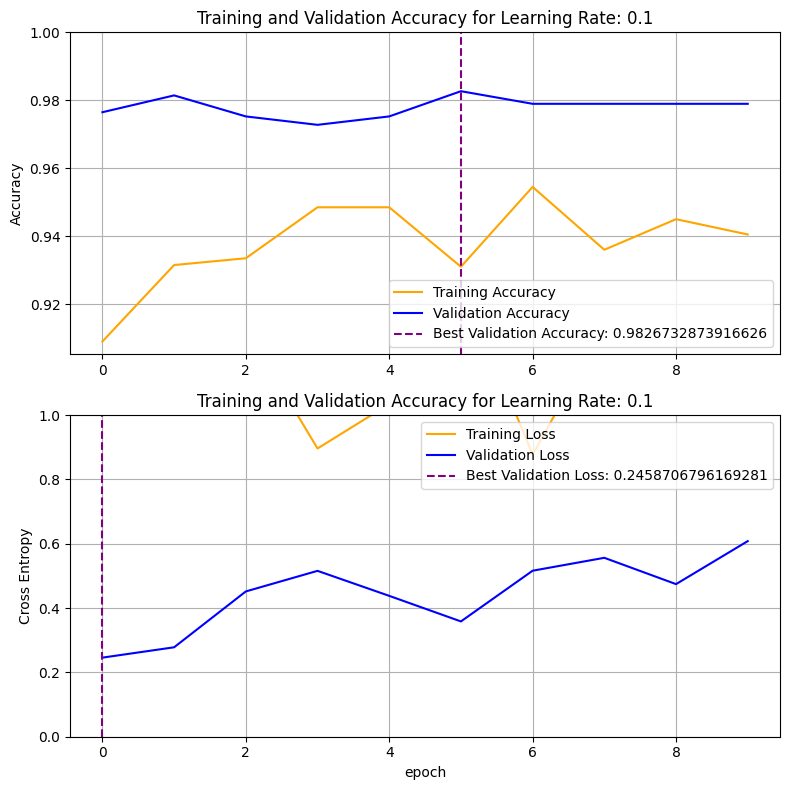

In [69]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
lr_history = {}
epochs = 10

for lr in learning_rates:
    print('\033[35m' + 'Learning rate: ' + str(lr) + '\033[0m')
    model = build()
    history = train(model, learning_rate=lr, epochs=epochs, plot_label=False, title='Training and Validation Accuracy for Learning Rate: ' + str(lr))
    lr_history[lr] = history

Epochs: 10
Epoch 1/10
63/63 [==============================] - 6s 75ms/step - loss: 1.4165 - accuracy: 0.9620 - val_loss: 0.8828 - val_accuracy: 0.9777
Epoch 2/10
63/63 [==============================] - 4s 61ms/step - loss: 1.2257 - accuracy: 0.9620 - val_loss: 0.8719 - val_accuracy: 0.9777
Epoch 3/10
63/63 [==============================] - 4s 60ms/step - loss: 1.3877 - accuracy: 0.9655 - val_loss: 0.8748 - val_accuracy: 0.9777
Epoch 4/10
63/63 [==============================] - 4s 59ms/step - loss: 1.3773 - accuracy: 0.9590 - val_loss: 0.7806 - val_accuracy: 0.9802
Epoch 5/10
63/63 [==============================] - 4s 60ms/step - loss: 0.9557 - accuracy: 0.9695 - val_loss: 0.7856 - val_accuracy: 0.9802
Epoch 6/10
63/63 [==============================] - 4s 60ms/step - loss: 1.1441 - accuracy: 0.9660 - val_loss: 0.8000 - val_accuracy: 0.9790
Epoch 7/10
63/63 [==============================] - 4s 60ms/step - loss: 1.0989 - accuracy: 0.9710 - val_loss: 0.8533 - val_accuracy: 0.9752
Ep

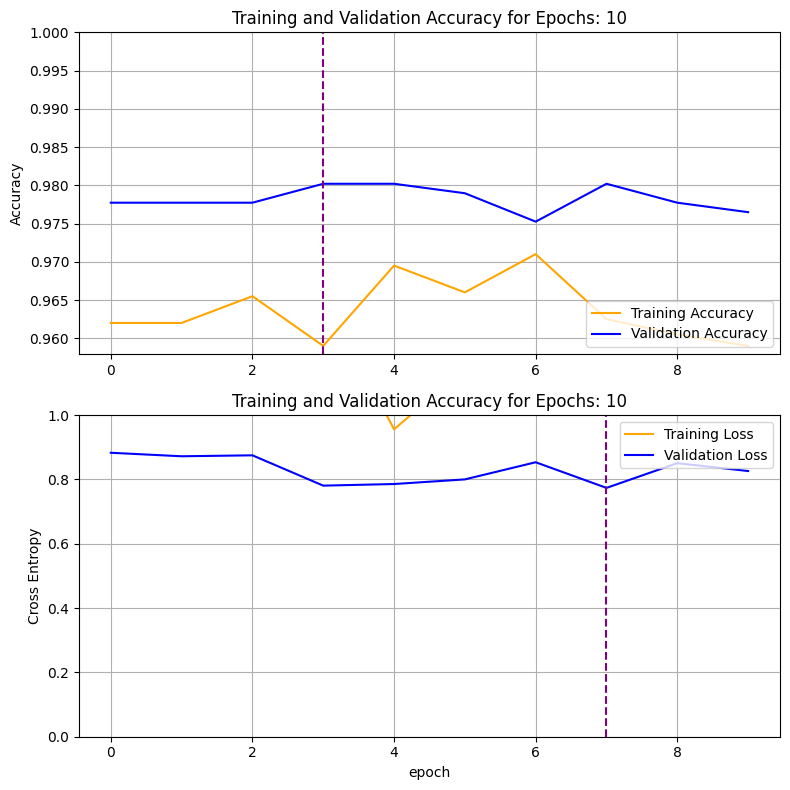

Epochs: 25
Epoch 1/25
63/63 [==============================] - 6s 74ms/step - loss: 0.9390 - accuracy: 0.9725 - val_loss: 0.6913 - val_accuracy: 0.9802
Epoch 2/25
63/63 [==============================] - 4s 61ms/step - loss: 1.2517 - accuracy: 0.9620 - val_loss: 0.7589 - val_accuracy: 0.9802
Epoch 3/25
63/63 [==============================] - 4s 61ms/step - loss: 1.1619 - accuracy: 0.9680 - val_loss: 0.7084 - val_accuracy: 0.9814
Epoch 4/25
63/63 [==============================] - 4s 62ms/step - loss: 1.0721 - accuracy: 0.9655 - val_loss: 0.6903 - val_accuracy: 0.9814
Epoch 5/25
63/63 [==============================] - 4s 62ms/step - loss: 1.1088 - accuracy: 0.9685 - val_loss: 0.8383 - val_accuracy: 0.9765
Epoch 6/25
63/63 [==============================] - 6s 88ms/step - loss: 0.9763 - accuracy: 0.9655 - val_loss: 0.8361 - val_accuracy: 0.9740
Epoch 7/25
63/63 [==============================] - 6s 101ms/step - loss: 1.1510 - accuracy: 0.9635 - val_loss: 0.7806 - val_accuracy: 0.9765
E

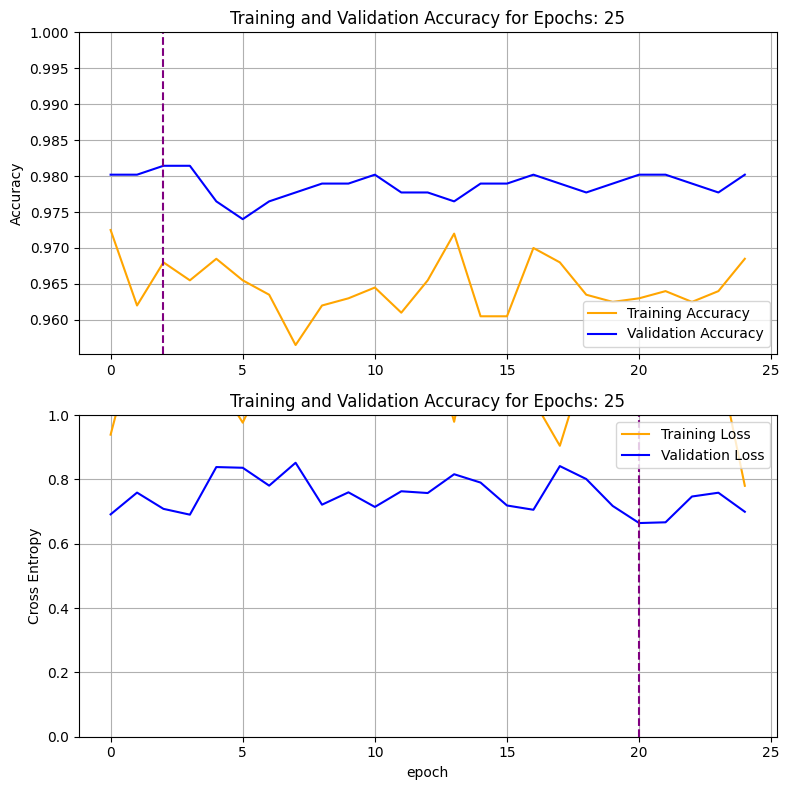

Epochs: 50
Epoch 1/50
63/63 [==============================] - 12s 125ms/step - loss: 1.2846 - accuracy: 0.9600 - val_loss: 0.7038 - val_accuracy: 0.9802
Epoch 2/50
63/63 [==============================] - 7s 106ms/step - loss: 1.4946 - accuracy: 0.9580 - val_loss: 0.6638 - val_accuracy: 0.9802
Epoch 3/50
63/63 [==============================] - 7s 106ms/step - loss: 0.9844 - accuracy: 0.9670 - val_loss: 0.6604 - val_accuracy: 0.9802
Epoch 4/50
63/63 [==============================] - 7s 113ms/step - loss: 1.1490 - accuracy: 0.9640 - val_loss: 0.6562 - val_accuracy: 0.9814
Epoch 5/50
63/63 [==============================] - 7s 110ms/step - loss: 1.3335 - accuracy: 0.9615 - val_loss: 0.7958 - val_accuracy: 0.9777
Epoch 6/50
63/63 [==============================] - 7s 114ms/step - loss: 1.0601 - accuracy: 0.9670 - val_loss: 0.7599 - val_accuracy: 0.9752
Epoch 7/50
63/63 [==============================] - 6s 98ms/step - loss: 1.3332 - accuracy: 0.9595 - val_loss: 0.7926 - val_accuracy: 0.

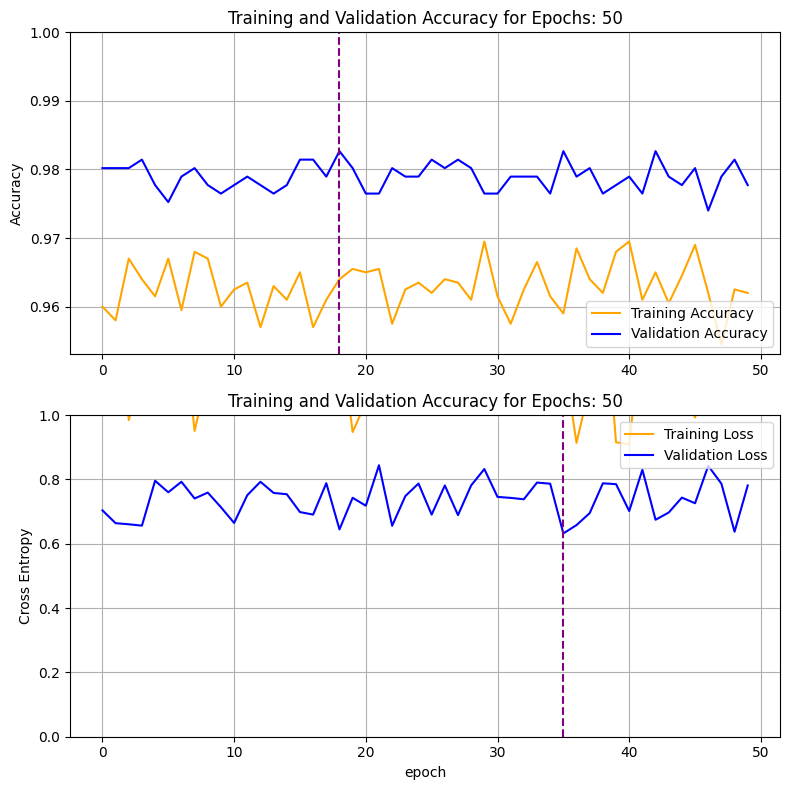

Epochs: 100
Epoch 1/100
63/63 [==============================] - 7s 79ms/step - loss: 1.1229 - accuracy: 0.9605 - val_loss: 0.7319 - val_accuracy: 0.9802
Epoch 2/100
63/63 [==============================] - 4s 66ms/step - loss: 1.0277 - accuracy: 0.9645 - val_loss: 0.7075 - val_accuracy: 0.9777
Epoch 3/100
63/63 [==============================] - 4s 66ms/step - loss: 1.2311 - accuracy: 0.9620 - val_loss: 0.7319 - val_accuracy: 0.9790
Epoch 4/100
63/63 [==============================] - 4s 65ms/step - loss: 0.8605 - accuracy: 0.9685 - val_loss: 0.7813 - val_accuracy: 0.9777
Epoch 5/100
63/63 [==============================] - 4s 64ms/step - loss: 1.2225 - accuracy: 0.9625 - val_loss: 0.6529 - val_accuracy: 0.9777
Epoch 6/100
63/63 [==============================] - 4s 61ms/step - loss: 1.7436 - accuracy: 0.9540 - val_loss: 0.6849 - val_accuracy: 0.9790
Epoch 7/100
63/63 [==============================] - 4s 63ms/step - loss: 1.1656 - accuracy: 0.9615 - val_loss: 0.6944 - val_accuracy: 0

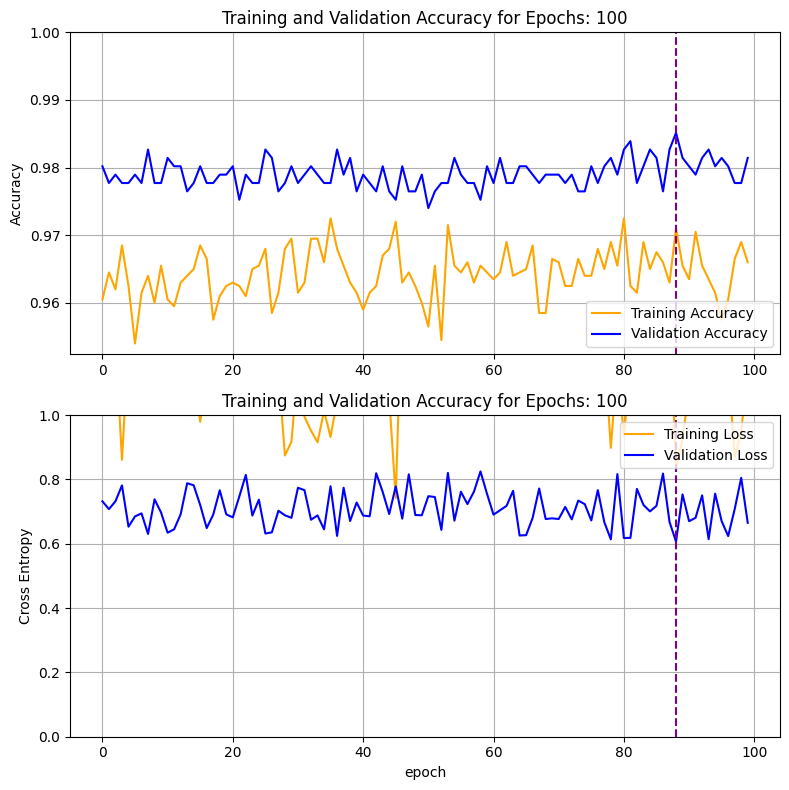

In [115]:
epochs = [10, 25, 50, 100]
epoch_history = {}

for epoch in epochs:
    print('\033[35m' + 'Epochs: ' + str(epoch) + '\033[0m')
    model = build()
    history = train(model, learning_rate=0.0001, epochs=epoch, plot_label=True, title='Training and Validation Accuracy for Epochs: ' + str(epoch))
    epoch_history[epoch] = history

In [55]:
def plot_lr(lr_history, title='Validation Accuracy and Loss for different learning rates', x_label='Learning Rate', y_label='Metric Value', plot_label="lr ="):
    """
        Function to plot the validation accuracy and loss for different learning rates

        Args:
            lr_history: Dictionary containing the history of training for different learning rates
            title: Title of the plot

    """
    # Plotting a bar graph for the different learning rates, and in each learning rate, displaying a bar for the validation accuracy and loss
    plt.figure(figsize=(10, 7))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(list(lr_history.keys()), rotation=45)

    # Setting the colors for the bar graphs
    colors = ['orange', 'blue', 'green', 'purple', 'cyan', 'red', 'pink', 'yellow', 'brown', 'lime']

    # Calculate the width of each bar and the separation between bar groups
    bar_width = 0.3
    bar_sep = 0.005

    for i, lr in enumerate(sorted(lr_history.keys())):
        # Calculate the x coordinates for the bars
        x_coords = [i - bar_width / 2, i + bar_width / 2]
        
        # Plot the bars
        plt.bar(x_coords, [np.max(lr_history[lr].history['val_accuracy']), np.min(lr_history[lr].history['val_loss'])], width=bar_width, label=plot_label + str(lr), color=random.choice(colors), edgecolor='black')
        
        # Add text above the bars
        plt.text(x_coords[0] - 0.13, np.max(lr_history[lr].history['val_accuracy']) + 0.005, 'Acc: ' + str(round(np.max(lr_history[lr].history['val_accuracy']),3)), color='black', fontweight='bold')
        plt.text(x_coords[1]- 0.13, np.min(lr_history[lr].history['val_loss']) + 0.005, 'Loss: ' + str(round(np.min(lr_history[lr].history['val_loss']),3)), color='black', fontweight='bold')

    # Set the x ticks to the learning rates
    plt.xticks(range(len(lr_history.keys())), sorted(lr_history.keys()))
        
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('plots/' + title + '.png')
    plt.show()

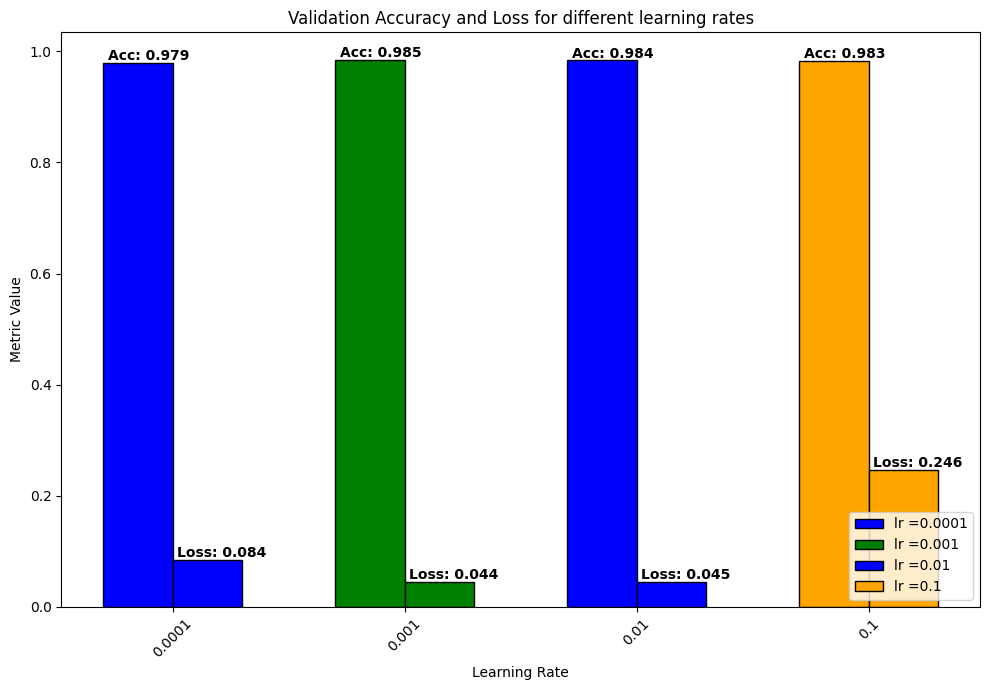

In [70]:
plot_lr(lr_history)

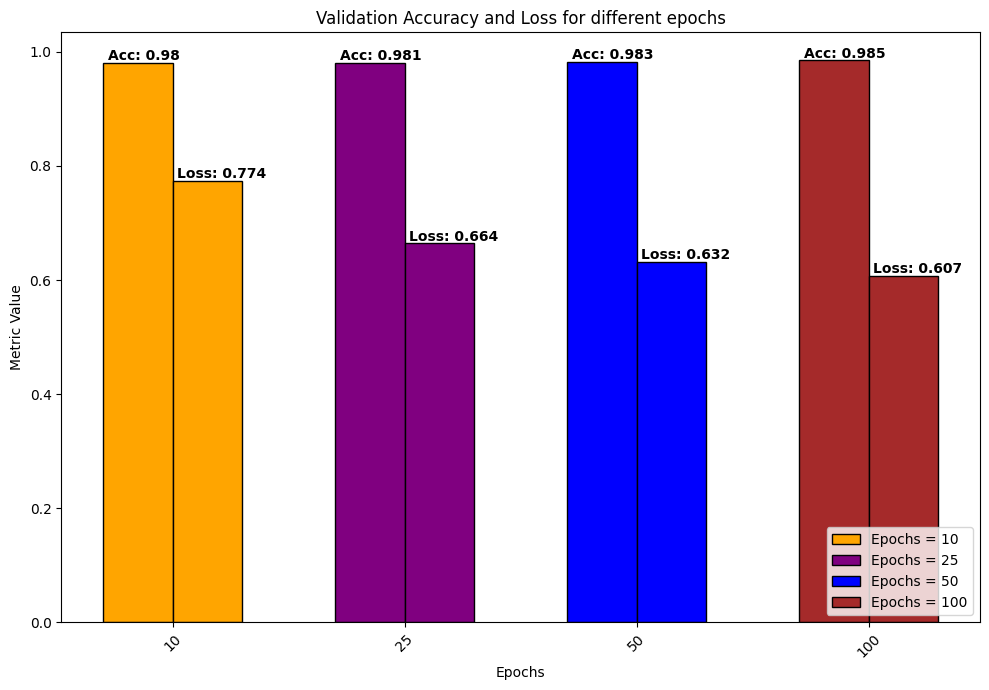

In [144]:
plot_lr(epoch_history, title='Validation Accuracy and Loss for different epochs', x_label='Epochs', y_label='Metric Value', plot_label=True)

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [45]:
base_model.trainable = True

In [46]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [47]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [48]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [49]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [50]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 7s 75ms/step - loss: 0.5739 - accuracy: 0.7085 - val_loss: 0.4505 - val_accuracy: 0.7884
Epoch 11/20
63/63 [==============================] - 4s 69ms/step - loss: 0.5362 - accuracy: 0.7335 - val_loss: 0.4164 - val_accuracy: 0.8057
Epoch 12/20
63/63 [==============================] - 4s 69ms/step - loss: 0.5060 - accuracy: 0.7490 - val_loss: 0.3864 - val_accuracy: 0.8292
Epoch 13/20
63/63 [==============================] - 4s 70ms/step - loss: 0.4649 - accuracy: 0.7745 - val_loss: 0.4241 - val_accuracy: 0.8020
Epoch 14/20
63/63 [==============================] - 7s 106ms/step - loss: 0.4520 - accuracy: 0.7760 - val_loss: 0.3601 - val_accuracy: 0.8416
Epoch 15/20
63/63 [==============================] - 7s 113ms/step - loss: 0.4317 - accuracy: 0.7920 - val_loss: 0.3481 - val_accuracy: 0.8366
Epoch 16/20
63/63 [==============================] - 7s 111ms/step - loss: 0.4284 - accuracy: 0.8010 - val_loss: 0.3516 - val_accuracy: 0.8329
Epoch 17/20
63/

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [51]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

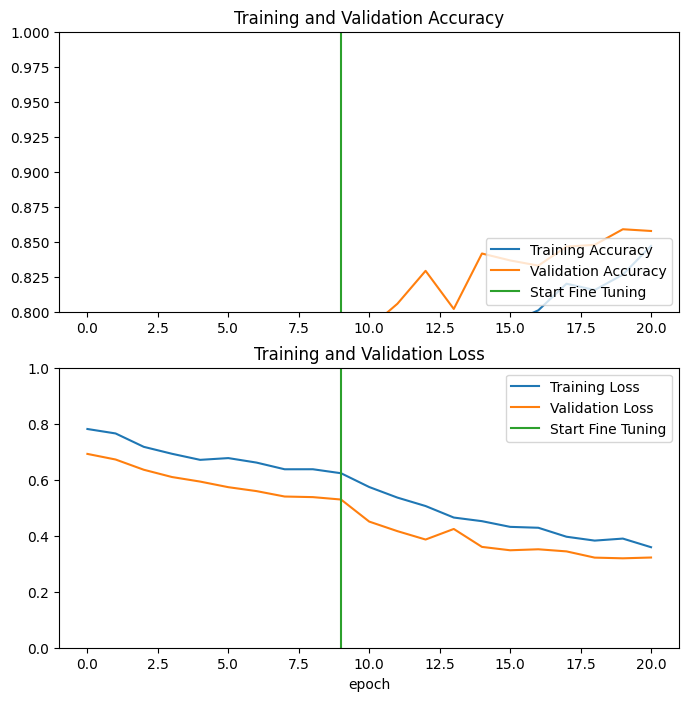

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
def train_optimizer(model, learning_rate=0.0001/10, epochs=10, optimizer=tf.keras.optimizers.Adam, title='Training and Validation Accuracy', base_model = base_model, optimizer_name='Adam'):
    """
        Function to train the model

        Args:
            model: Model to train
            learning_rate: Learning rate for the optimizer
            epochs: Number of epochs to train
            optimizer: Optimizer to use for training
            optimizer_name: Name of the optimizer

        Returns:
            History of the training
    """
    base_model = base_model

    # Setting the best model.trainable to True
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Compiling the model
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])
    
    # Training the model
    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=validation_dataset)
    
    # Retrieving the accuracy and loss values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Training the model
    fine_tune_epochs = 10
    total_epochs =  epochs + fine_tune_epochs

    history_fine = model.fit(train_dataset,
                            epochs=total_epochs,
                            initial_epoch=history.epoch[-1],
                            validation_data=validation_dataset)
        
    
    # Retrieving the accuracy and loss values from the history object
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

    # Plotting the training and validation accuracy for the different optimizers
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color='orange')
    plt.plot(val_acc, label='Validation Accuracy', color='blue')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.plot([epochs-1,epochs-1],
            plt.ylim(), label='Start Fine Tuning', color='lime')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.grid()
    plt.tight_layout()

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss', color='orange')
    plt.plot(val_loss, label='Validation Loss', color='blue')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.plot([epochs-1,epochs-1],
            plt.ylim(), label='Start Fine Tuning', color='lime')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel('epoch')
    plt.grid()
    plt.tight_layout()
    
    # Saving the plot
    if not os.path.exists('plots'):
        os.mkdir('plots')

    plt.savefig('plots/' + optimizer_name + '.png')

    plt.show()

    return history_fine 

Optimizer: SGD
Epoch 1/10
63/63 [==============================] - 6s 71ms/step - loss: 0.2220 - accuracy: 0.9250 - val_loss: 0.1041 - val_accuracy: 0.9802
Epoch 2/10
63/63 [==============================] - 6s 98ms/step - loss: 0.1500 - accuracy: 0.9485 - val_loss: 0.0837 - val_accuracy: 0.9814
Epoch 3/10
63/63 [==============================] - 7s 109ms/step - loss: 0.1452 - accuracy: 0.9450 - val_loss: 0.0697 - val_accuracy: 0.9839
Epoch 4/10
63/63 [==============================] - 7s 112ms/step - loss: 0.1343 - accuracy: 0.9500 - val_loss: 0.0657 - val_accuracy: 0.9827
Epoch 5/10
63/63 [==============================] - 7s 111ms/step - loss: 0.1259 - accuracy: 0.9510 - val_loss: 0.0670 - val_accuracy: 0.9851
Epoch 6/10
63/63 [==============================] - 7s 112ms/step - loss: 0.1360 - accuracy: 0.9440 - val_loss: 0.0615 - val_accuracy: 0.9851
Epoch 7/10
63/63 [==============================] - 7s 112ms/step - loss: 0.1065 - accuracy: 0.9600 - val_loss: 0.0542 - val_accuracy: 

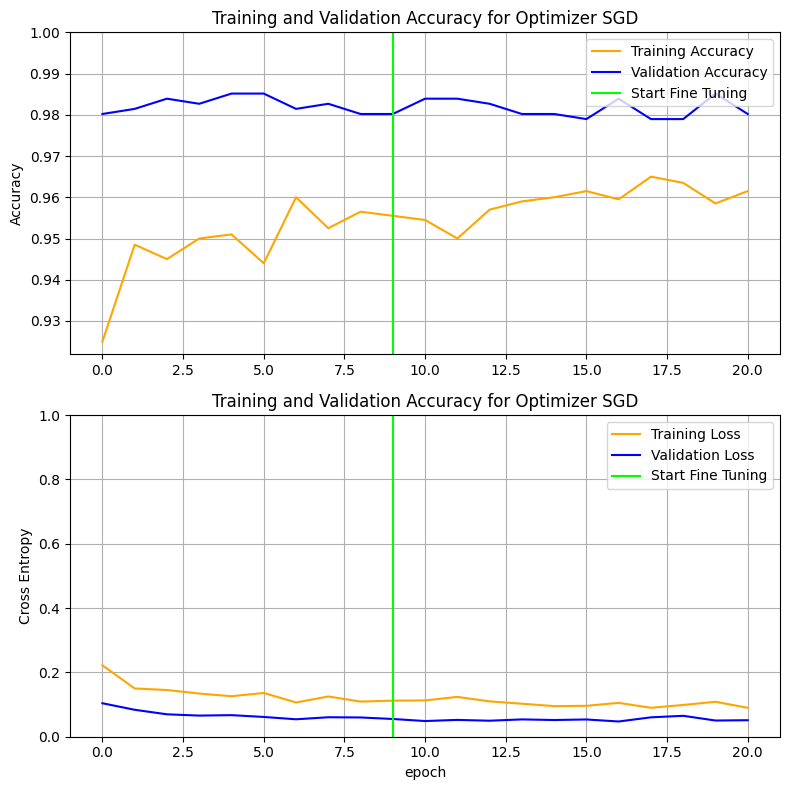

Optimizer: RMSprop
Epoch 1/10
63/63 [==============================] - 11s 98ms/step - loss: 0.3071 - accuracy: 0.8845 - val_loss: 0.0559 - val_accuracy: 0.9777
Epoch 2/10
63/63 [==============================] - 5s 73ms/step - loss: 0.1857 - accuracy: 0.9325 - val_loss: 0.6767 - val_accuracy: 0.7933
Epoch 3/10
63/63 [==============================] - 4s 69ms/step - loss: 0.1589 - accuracy: 0.9400 - val_loss: 0.0614 - val_accuracy: 0.9728
Epoch 4/10
63/63 [==============================] - 5s 74ms/step - loss: 0.1224 - accuracy: 0.9535 - val_loss: 0.0754 - val_accuracy: 0.9740
Epoch 5/10
63/63 [==============================] - 7s 117ms/step - loss: 0.1180 - accuracy: 0.9540 - val_loss: 0.0748 - val_accuracy: 0.9740
Epoch 6/10
63/63 [==============================] - 8s 118ms/step - loss: 0.1001 - accuracy: 0.9595 - val_loss: 0.0561 - val_accuracy: 0.9814
Epoch 7/10
63/63 [==============================] - 8s 122ms/step - loss: 0.0850 - accuracy: 0.9650 - val_loss: 0.0680 - val_accurac

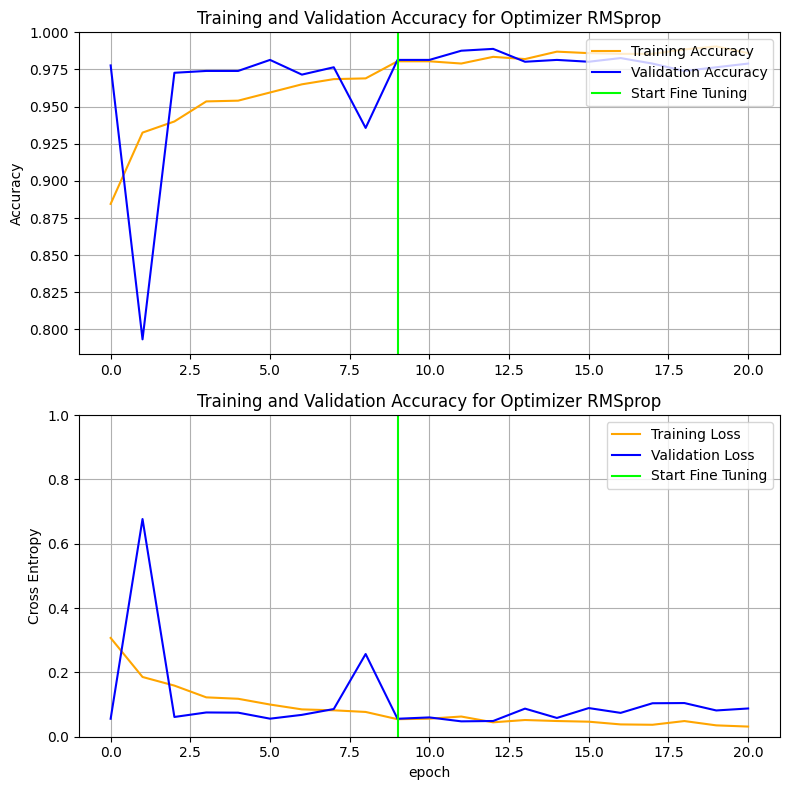

Optimizer: Adagrad
Epoch 1/10
63/63 [==============================] - 7s 82ms/step - loss: 0.1782 - accuracy: 0.9310 - val_loss: 0.0679 - val_accuracy: 0.9802
Epoch 2/10
63/63 [==============================] - 4s 69ms/step - loss: 0.1299 - accuracy: 0.9530 - val_loss: 0.0606 - val_accuracy: 0.9827
Epoch 3/10
63/63 [==============================] - 4s 68ms/step - loss: 0.1253 - accuracy: 0.9505 - val_loss: 0.0574 - val_accuracy: 0.9814
Epoch 4/10
63/63 [==============================] - 4s 66ms/step - loss: 0.1160 - accuracy: 0.9490 - val_loss: 0.0612 - val_accuracy: 0.9827
Epoch 5/10
63/63 [==============================] - 4s 67ms/step - loss: 0.1060 - accuracy: 0.9600 - val_loss: 0.0521 - val_accuracy: 0.9851
Epoch 6/10
63/63 [==============================] - 4s 67ms/step - loss: 0.0952 - accuracy: 0.9605 - val_loss: 0.0536 - val_accuracy: 0.9827
Epoch 7/10
63/63 [==============================] - 4s 69ms/step - loss: 0.0953 - accuracy: 0.9635 - val_loss: 0.0468 - val_accuracy: 0

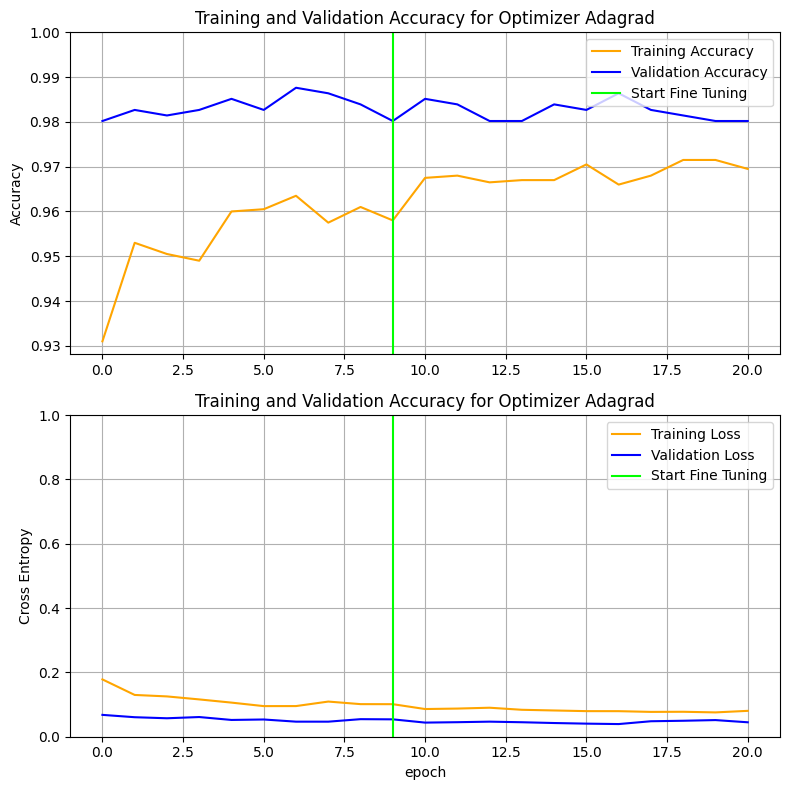

Optimizer: Adadelta
Epoch 1/10
63/63 [==============================] - 7s 81ms/step - loss: 0.3914 - accuracy: 0.8360 - val_loss: 0.1776 - val_accuracy: 0.9443
Epoch 2/10
63/63 [==============================] - 4s 66ms/step - loss: 0.3298 - accuracy: 0.8595 - val_loss: 0.1560 - val_accuracy: 0.9579
Epoch 3/10
63/63 [==============================] - 4s 67ms/step - loss: 0.2938 - accuracy: 0.8845 - val_loss: 0.1544 - val_accuracy: 0.9616
Epoch 4/10
63/63 [==============================] - 4s 66ms/step - loss: 0.2649 - accuracy: 0.8990 - val_loss: 0.1395 - val_accuracy: 0.9715
Epoch 5/10
63/63 [==============================] - 4s 67ms/step - loss: 0.2626 - accuracy: 0.8920 - val_loss: 0.1299 - val_accuracy: 0.9728
Epoch 6/10
63/63 [==============================] - 4s 66ms/step - loss: 0.2398 - accuracy: 0.9070 - val_loss: 0.1318 - val_accuracy: 0.9728
Epoch 7/10
63/63 [==============================] - 4s 67ms/step - loss: 0.2314 - accuracy: 0.9155 - val_loss: 0.1290 - val_accuracy: 

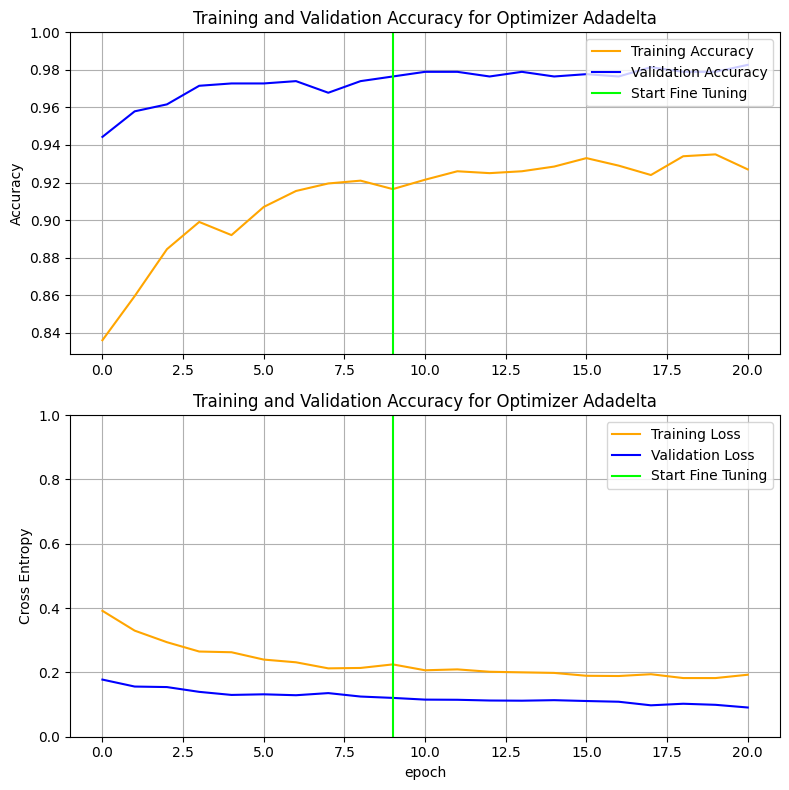

Optimizer: Adam
Epoch 1/10
63/63 [==============================] - 7s 82ms/step - loss: 0.1742 - accuracy: 0.9275 - val_loss: 0.0733 - val_accuracy: 0.9641
Epoch 2/10
63/63 [==============================] - 4s 67ms/step - loss: 0.0994 - accuracy: 0.9580 - val_loss: 0.1009 - val_accuracy: 0.9554
Epoch 3/10
63/63 [==============================] - 4s 68ms/step - loss: 0.1274 - accuracy: 0.9460 - val_loss: 0.0556 - val_accuracy: 0.9790
Epoch 4/10
63/63 [==============================] - 4s 66ms/step - loss: 0.0792 - accuracy: 0.9760 - val_loss: 0.0401 - val_accuracy: 0.9839
Epoch 5/10
63/63 [==============================] - 4s 67ms/step - loss: 0.0853 - accuracy: 0.9670 - val_loss: 0.0519 - val_accuracy: 0.9839
Epoch 6/10
63/63 [==============================] - 4s 67ms/step - loss: 0.0490 - accuracy: 0.9850 - val_loss: 0.0510 - val_accuracy: 0.9790
Epoch 7/10
63/63 [==============================] - 4s 66ms/step - loss: 0.0683 - accuracy: 0.9750 - val_loss: 0.0589 - val_accuracy: 0.97

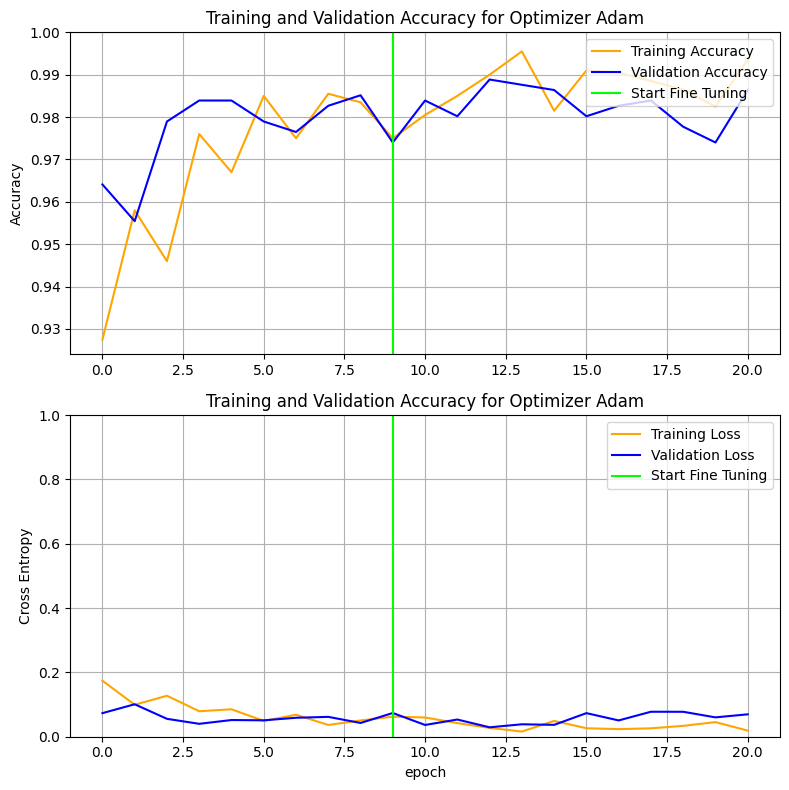

Optimizer: Adamax
Epoch 1/10
63/63 [==============================] - 7s 80ms/step - loss: 0.1700 - accuracy: 0.9305 - val_loss: 0.0430 - val_accuracy: 0.9864
Epoch 2/10
63/63 [==============================] - 4s 66ms/step - loss: 0.0994 - accuracy: 0.9595 - val_loss: 0.0477 - val_accuracy: 0.9876
Epoch 3/10
63/63 [==============================] - 4s 66ms/step - loss: 0.0803 - accuracy: 0.9680 - val_loss: 0.0405 - val_accuracy: 0.9839
Epoch 4/10
63/63 [==============================] - 4s 66ms/step - loss: 0.0826 - accuracy: 0.9700 - val_loss: 0.0929 - val_accuracy: 0.9653
Epoch 5/10
63/63 [==============================] - 4s 66ms/step - loss: 0.0773 - accuracy: 0.9685 - val_loss: 0.0364 - val_accuracy: 0.9814
Epoch 6/10
63/63 [==============================] - 4s 67ms/step - loss: 0.0497 - accuracy: 0.9795 - val_loss: 0.0442 - val_accuracy: 0.9827
Epoch 7/10
63/63 [==============================] - 4s 67ms/step - loss: 0.0506 - accuracy: 0.9810 - val_loss: 0.0496 - val_accuracy: 0.

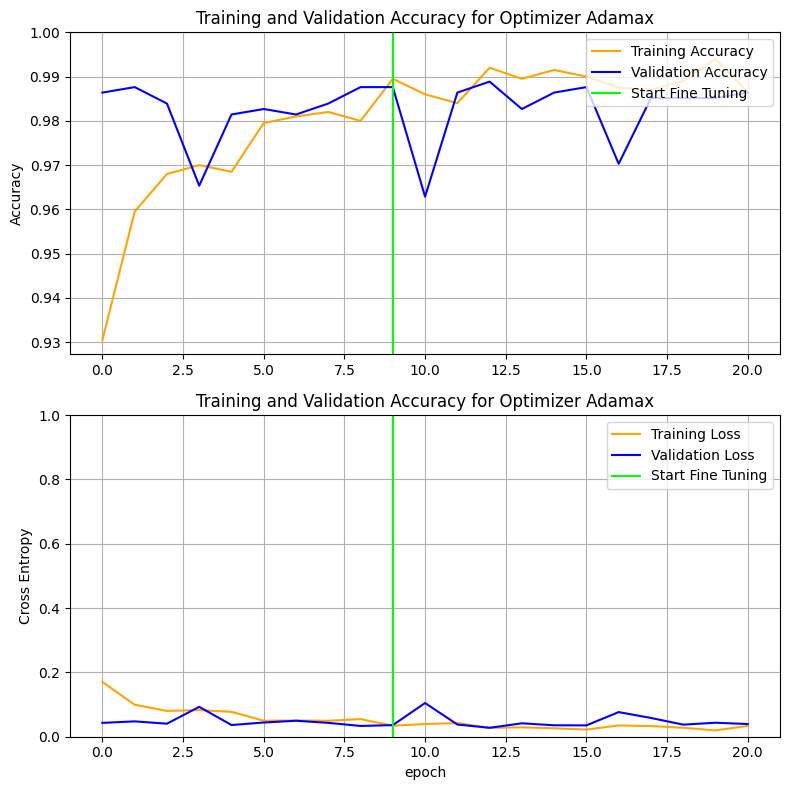

Optimizer: Nadam
Epoch 1/10
63/63 [==============================] - 9s 86ms/step - loss: 0.1855 - accuracy: 0.9260 - val_loss: 0.1030 - val_accuracy: 0.9567
Epoch 2/10
63/63 [==============================] - 5s 73ms/step - loss: 0.1231 - accuracy: 0.9490 - val_loss: 0.0387 - val_accuracy: 0.9839
Epoch 3/10
63/63 [==============================] - 5s 74ms/step - loss: 0.1122 - accuracy: 0.9535 - val_loss: 0.0579 - val_accuracy: 0.9790
Epoch 4/10
63/63 [==============================] - 5s 72ms/step - loss: 0.1106 - accuracy: 0.9555 - val_loss: 0.0533 - val_accuracy: 0.9851
Epoch 5/10
63/63 [==============================] - 5s 74ms/step - loss: 0.0561 - accuracy: 0.9785 - val_loss: 0.0769 - val_accuracy: 0.9790
Epoch 6/10
63/63 [==============================] - 5s 72ms/step - loss: 0.0671 - accuracy: 0.9775 - val_loss: 0.0532 - val_accuracy: 0.9814
Epoch 7/10
63/63 [==============================] - 5s 73ms/step - loss: 0.0672 - accuracy: 0.9730 - val_loss: 0.0834 - val_accuracy: 0.9

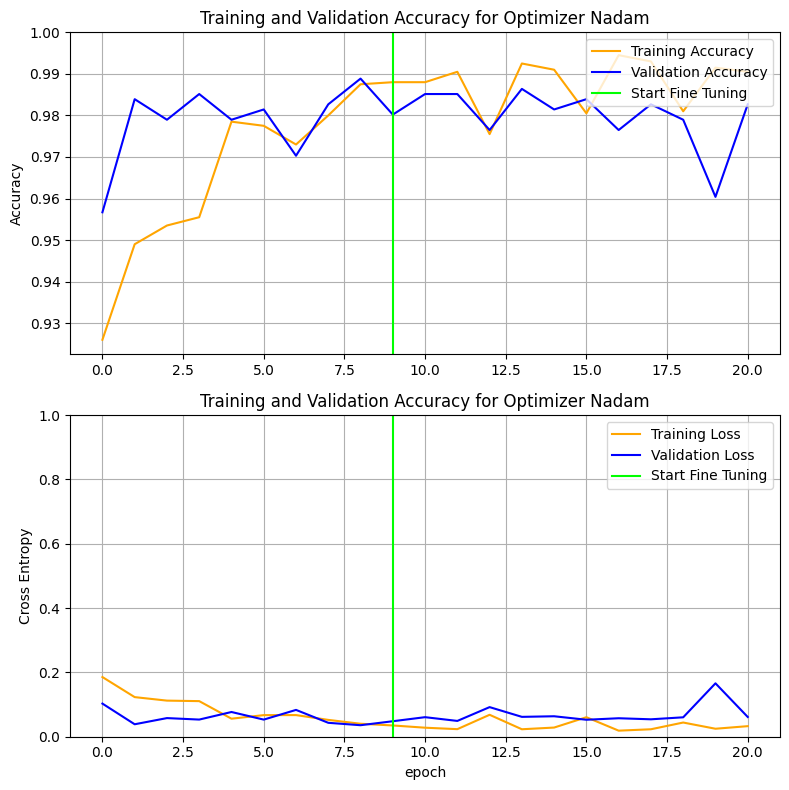

In [53]:
optimizers = [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam]

optimizer_history = {}

for optimizer in optimizers:
    optimizer_name = str(optimizer).split(' ')[1].split('.')[-1].split("'")[0]

    print('\033[35m' + 'Optimizer: ' + str(optimizer_name) + '\033[0m')
    
    # Recreate the base model at the start of each loop iteration
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')

    model = build(new_base_model=base_model)
    history = train_optimizer(model, learning_rate=0.0001, epochs=10, optimizer=optimizer, title='Training and Validation Accuracy for Optimizer ' + str(optimizer_name), base_model=base_model, optimizer_name=optimizer_name)
    optimizer_history[optimizer_name] = history

In [65]:
def plot_optimizer(optimizer_history, title='Validation Accuracy and Loss for different optimizers', x_label='Optimizer', y_label='Metric Value', plot_label="Optimizer ="):
    """
        Function to plot the validation accuracy and loss for different optimizers

        Args:
            optimizer_history: Dictionary containing the history of training for different optimizers
            title: Title of the plot

    """
    # Plotting a bar graph for the different optimizers, and in each optimizer, displaying a bar for the validation accuracy and loss
    plt.figure(figsize=(10, 7))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(range(len(optimizer_history.keys())), sorted(optimizer_history.keys()), rotation=45)

    # Setting the colors for the bar graphs
    colors = ['orange', 'blue', 'green', 'purple', 'cyan', 'red', 'pink', 'yellow', 'brown', 'lime']

    # Calculate the width of each bar and the separation between bar groups
    bar_width = 0.3
    bar_sep = 0.005

    for i, optimizer in enumerate(sorted(optimizer_history.keys())):
        # Calculate the x coordinates for the bars
        x_coords = [i - bar_width / 2, i + bar_width / 2]
        
        # Plot the bars
        plt.bar(x_coords, [np.max(optimizer_history[optimizer].history['val_accuracy']), np.min(optimizer_history[optimizer].history['val_loss'])], width=bar_width, label=plot_label + str(optimizer), color=colors.pop(), edgecolor='black')
        
        # Add text above the bars
        plt.text(x_coords[0] - 0.13, np.max(optimizer_history[optimizer].history['val_accuracy']) + 0.005, 'Acc: ' + str(round(np.max(optimizer_history[optimizer].history['val_accuracy']),3)), color='black', fontweight='bold', fontsize=8)
        plt.text(x_coords[1]- 0.13, np.min(optimizer_history[optimizer].history['val_loss']) + 0.005, 'Loss: ' + str(round(np.min(optimizer_history[optimizer].history['val_loss']),3)), color='black', fontweight='bold', fontsize=8)

    # Set the x ticks to the optimizers
    plt.xticks(range(len(optimizer_history.keys())), sorted(optimizer_history.keys()))
        
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('plots/' + title + '.png')
    plt.show()


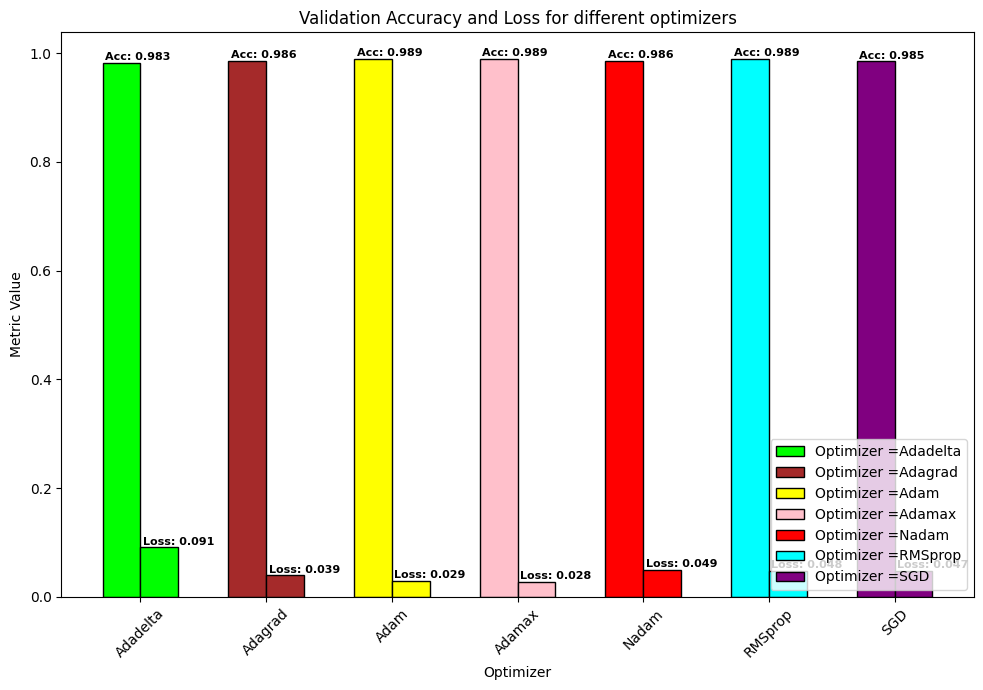

In [67]:
plot_optimizer(optimizer_history)

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [53]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 17ms/step - loss: 0.3246 - accuracy: 0.8542
Test accuracy : 0.8541666865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1]
Labels:
 [0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0]


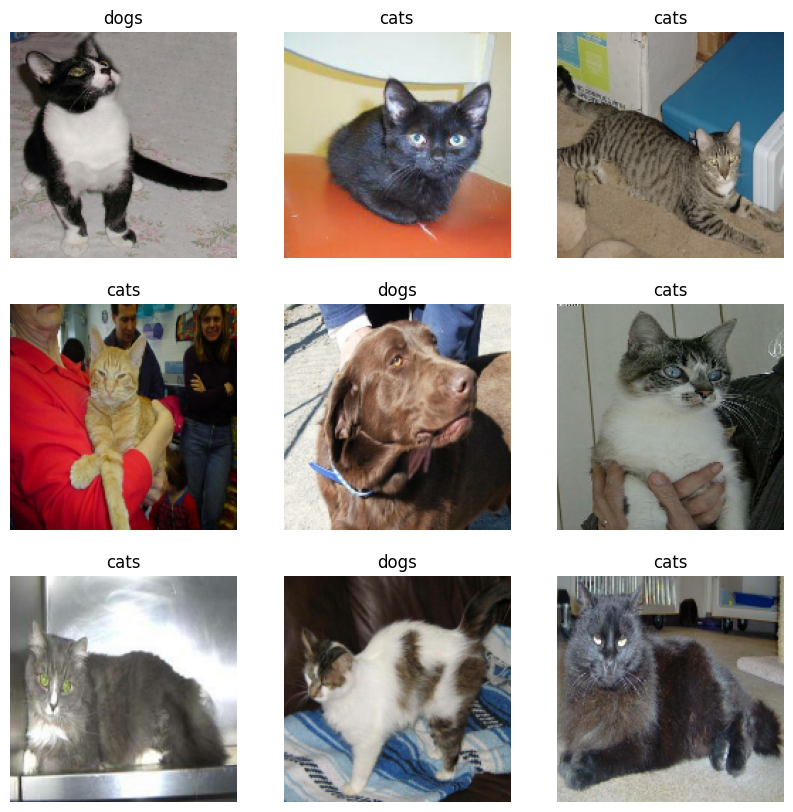

In [54]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
